In [1]:
import mlflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from mlflow import log_metric, log_param, log_artifacts

In [2]:
data = pd.read_csv('data/train.csv')

X, y = data.drop('label', axis=1), data['label'].values

X = X.to_numpy().reshape((len(X), 28, 28))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

c:\users\u02vpe\deeplearningspecialization\tensorflow_testing\mnist\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in X_train, X_test, y_train, y_test: 
    print(i.shape)

In [ ]:
#mlflow.create_experiment("mnist_dense")
mlflow.set_experiment("mnist_conv")
mlflow.start_run(run_name='batch_norm')
mlflow.keras.autolog()

In [ ]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=[28, 28, 1]))
# model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dropout(0.25))
# model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dropout(0.25))
# model.add(tf.keras.layers.Dense(60, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dropout(0.25))
# model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=12, padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(kernel_size=6, filters=24, padding='same', strides=2, use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(kernel_size=6, filters=32, padding='same', strides=2, use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Flatten(),
                           
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),  
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(10, activation='softmax')
])


def lr_decay(epoch):
    return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='sparse_categorical_crossentropy',  # Sparse for integers, just categorical for one hot encoded
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

steps_per_epoch = len(X_train)//128

model.fit(X_train, y_train, 
          epochs=20, 
          batch_size=128,
          steps_per_epoch=steps_per_epoch,
          validation_split=0.1, 
          callbacks=[early_stop, lr_decay_callback])

In [ ]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig("output/accuracy_per_epoch.png")

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig("output/loss_per_epoch.png")

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test)

In [ ]:
# mlflow.log_artifact("output/accuracy_per_epoch.png")
# mlflow.log_artifact("output/loss_per_epoch.png")
log_metric("final_test_accuracy", val_acc)

In [ ]:
mlflow.end_run()

In [ ]:
# predict testset

In [3]:
#retrain
data = pd.read_csv('data/test.csv')

data = data.to_numpy().reshape((len(data), 28, 28))

X_train = tf.keras.utils.normalize(X, axis=1)
X_test = tf.keras.utils.normalize(data, axis=1)

In [4]:
X_train.shape, X_test.shape

((42000, 28, 28), (28000, 28, 28))

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=12, padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(kernel_size=6, filters=24, padding='same', strides=2, use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(kernel_size=6, filters=32, padding='same', strides=2, use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Flatten(),
                           
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),  
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation='softmax')
])

def lr_decay(epoch):
    return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='sparse_categorical_crossentropy',  # Sparse for integers, just categorical for one hot encoded
              metrics=['accuracy'])

steps_per_epoch = len(X_train)//64

model.fit(X_train, y, 
          epochs=10, 
          batch_size=64,
          steps_per_epoch=steps_per_epoch,
          callbacks=[lr_decay_callback],
          shuffle=True)

c:\users\u02vpe\deeplearningspecialization\tensorflow_testing\mnist\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()



Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
656/656 [==============================] - 52s 79ms/step - loss: 0.1552 - accuracy: 0.9524 - lr: 0.0100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00666.
Epoch 2/10
656/656 [==============================] - 54s 83ms/step - loss: 0.0528 - accuracy: 0.9843 - lr: 0.0067

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004435560000000001.
Epoch 3/10
656/656 [==============================] - 56s 85ms/step - loss: 0.0350 - accuracy: 0.9894 - lr: 0.0044

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0029540829600000007.
Epoch 4/10
656/656 [==============================] - 56s 86ms/step - loss: 0.0216 - accuracy: 0.9930 - lr: 0.0030

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0019674192513600007.
Epoch 5/10
656/656 [==============================] - 56s 86ms/step - loss: 0.0127 - accuracy: 0.9964 - lr: 0.0020

Epoch 00006: LearningRateSchedu

In [20]:
preds = model.predict(X_test)

In [21]:
output = pd.DataFrame({'ImageId': range(1, len(preds)+1), 'Label': np.argmax(preds, axis=1)})

In [22]:
output.head(9)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0


c:\users\u02vpe\deeplearningspecialization\tensorflow_testing\mnist\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Populating the interactive namespace from numpy and matplotlib


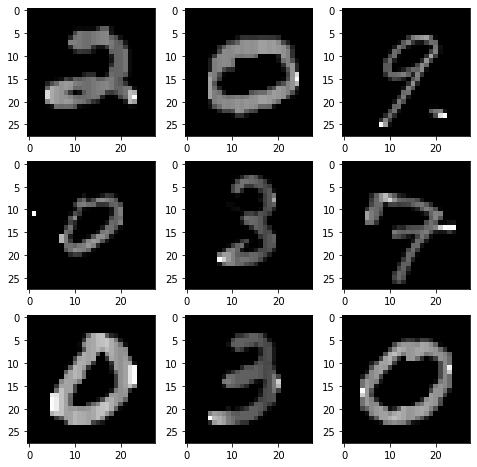

In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)

for i in range(9):
    _ = plt.subplot(3, 3, i+1)
    _ = plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))

In [24]:
output.to_csv('output/submission2.csv', index=False)